# Learning

Okay. Learning from the previous failures, we can come up with some new techniques for making the network better.

1. Train using both 5' and 3' data (because we want to learn a model for skipped exons)
2. Use a deeper model? More layers?

Honestly this notebook is a mess. I tried training and re-training the models over and over, and sometimes testing results in incongrouous places.

In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
reload(nn_utils)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

import tqdm

Using Theano backend.


## Loading Synthetic Data

This time we'll be loading both alt-5' and alt-3' data.

In [2]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [3]:
X_a3_train, X_a3_test, Y_a3_train, Y_a3_test = nn_utils.load_a3_data()
# position 235 corresponds to splice site 1?
Y2_a3_test = Y_a3_test[:,235]
Y2_a3_train = Y_a3_train[:,235]
X1_a3_train = X_a3_train.map(lambda x: x[25:])
X1_a3_test = X_a3_test.map(lambda x: x[25:])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_a3_train = np.dstack(X1_a3_train)
X1_a3_train = np.rollaxis(X1_a3_train, 2)
X1_a3_test = np.dstack(X1_a3_test)
X1_a3_test = np.rollaxis(X1_a3_test, 2)

Y2_a3_train = Y2_a3_train.reshape((len(Y2_a3_train), 1))
Y2_a3_test = Y2_a3_test.reshape((len(Y2_a3_test), 1))

In [54]:
X_train = np.concatenate((X1_train, X1_a3_train), axis=0)
Y_train = np.concatenate((Y2_train, Y2_a3_train), axis=0)

## Loading Biological Data

In [4]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

## Model 1: Lots of Convolutions

In [2]:
num_filters = [64,64,32]
filter_length = [6,6,6]


model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(Dropout(0.25))
model1.add(MaxPooling1D(pool_length=2))
model1.add(Convolution1D(num_filters[2], filter_length[2], activation='relu'))
model1.add(Dropout(0.25))
model1.add(GRU(output_dim=num_filters[-1]))
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [7]:
model1.layers[-3].output_shape

(None, 32)

In [9]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '15301' (I am process '3673')


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 1360s - loss: 0.6204 - acc: 1.0000 - val_loss: 0.5802 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 1286s - loss: 0.5733 - acc: 1.0000 - val_loss: 0.5564 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 1337s - loss: 0.5617 - acc: 1.0000 - val_loss: 0.5550 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 1286s - loss: 0.5555 - acc: 1.0000 - val_loss: 0.5417 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 1266s - loss: 0.5524 - acc: 1.0000 - val_loss: 0.5393 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 1291s - loss: 0.5500 - acc: 1.0000 - val_loss: 0.5384 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 1326s - loss: 0.5480 - acc: 1.0000 - val_loss: 0.5434 - val_acc: 1.0000
Epoch 8/50
212035/212035 

KeyboardInterrupt: 

In [11]:
predictions = model1.predict(X1_test)

In [12]:
r2_score(Y2_test, predictions)

0.52410503333345537

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


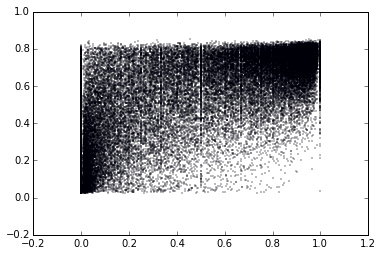

In [13]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

In [14]:
predictions2 = model1.predict(X1_a3_test)

In [15]:
r2_score(predictions2, Y2_a3_test)

-2.5192646085422927

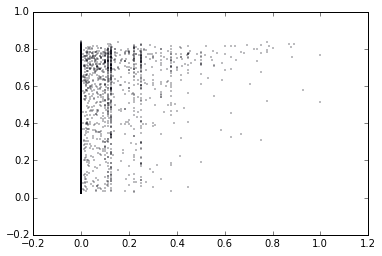

In [16]:
plt.scatter(Y2_a3_test, predictions2, s=0.1)
plt.show()

In [17]:
predictions2 = model1.predict(X1_a3_train)

In [18]:
r2_score(Y2_a3_train, predictions2)

-51.947829938823382

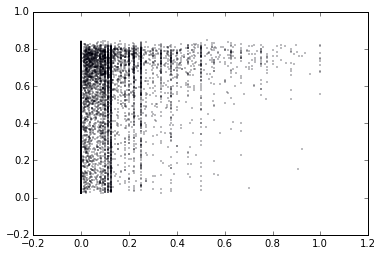

In [19]:
plt.scatter(Y2_a3_train, predictions2, s=0.1)
plt.show()

In [17]:
model1.save_weights('../data/convolutional-recurrent-5.h5')
model_json = model1.to_json()
with open('../data/convolutional-recurrent-5-model.json', 'w') as f:
    f.write(model_json)

## Testing dPSI for model1

In [21]:
from keras import backend as K

get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [23]:
expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

In [20]:
model1.layers    

In [24]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [25]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [26]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [27]:
r2_score(hal_pred, model_pred)

0.0026468122485791001

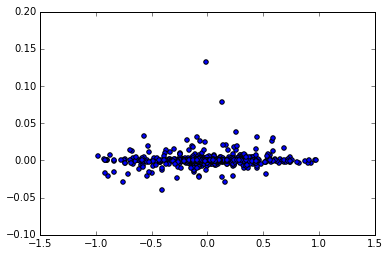

In [28]:
plt.scatter(hal_pred, model_pred)

In [29]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [30]:
r2_score(actual, model_pred_2)

-7.7676964371109491e-05

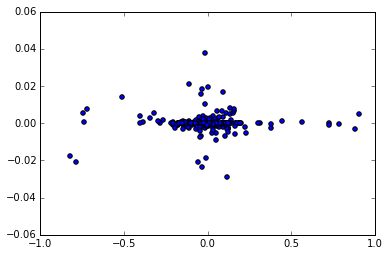

In [31]:
plt.scatter(actual, model_pred_2)

## Model 2: Purely Recurrent Model With 2 Layers

In [32]:
num_filters = [64,64,32]
filter_length = [6,6,6]


model2 = Sequential()
model2.add(GRU(num_filters[0], input_dim=4, return_sequences=True))
model2.add(Dropout(0.25))
model2.add(GRU(output_dim=num_filters[-1]))
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

In [33]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model2.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 154s - loss: 0.6575 - acc: 1.0000 - val_loss: 0.6033 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 148s - loss: 0.5878 - acc: 1.0000 - val_loss: 0.5701 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 767s - loss: 0.5727 - acc: 1.0000 - val_loss: 0.5629 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 155s - loss: 0.5657 - acc: 1.0000 - val_loss: 0.5572 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 158s - loss: 0.5610 - acc: 1.0000 - val_loss: 0.5582 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 161s - loss: 0.5558 - acc: 1.0000 - val_loss: 0.5492 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 152s - loss: 0.5512 - acc: 1.0000 - val_loss: 0.5437 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

In [35]:
predictions = model2.predict(X1_test)

In [36]:
r2_score(Y2_test, predictions)

0.60504827016652674

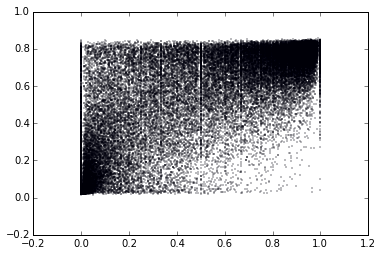

In [37]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

## Testing dPSI for model2

In [38]:
from keras import backend as K

get_3rd_layer_output_1 = K.function([model2.layers[0].input],
                                  [model2.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [39]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [40]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [41]:
r2_score(hal_pred, model_pred)

0.0029491993804922068

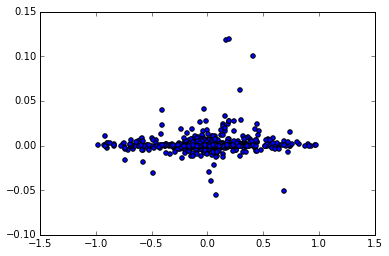

In [42]:
plt.scatter(hal_pred, model_pred)
plt.show()

In [43]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [44]:
r2_score(actual, model_pred_2)

-0.0062042395960169028

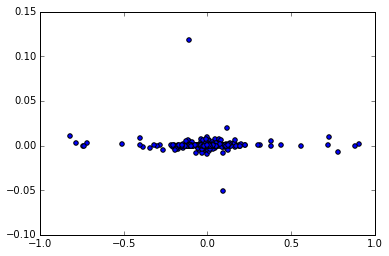

In [45]:
plt.scatter(actual, model_pred_2)
plt.show()

In [72]:
model2.save_weights('../data/recurrent-2.h5')
model_json = model2.to_json()
with open('../data/recurrent-2-model.json', 'w') as f:
    f.write(model_json)


The recurrent-only model seems to work surprisingly well, and is pretty fast to train. However, just like all the other networks, it utterly fails on predictions.

## Model 3: Deep Recurrent Network - 4 GRU layers

In [55]:
num_filters = [64,64,32]
filter_length = [6,6,6]


model3 = Sequential()
model3.add(GRU(num_filters[0], input_dim=4, return_sequences=True))
model3.add(Dropout(0.25))
model3.add(GRU(num_filters[1], return_sequences=True))
model3.add(Dropout(0.25))
model3.add(GRU(num_filters[2], return_sequences=True))
model3.add(Dropout(0.25))
model3.add(GRU(output_dim=num_filters[-1]))
model3.add(Dense(output_dim=1, activation='linear'))
model3.add(Activation('sigmoid'))

In [56]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam')

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model3.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 382s - loss: 0.6957 - acc: 1.0000 - val_loss: 0.6648 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 365s - loss: 0.6084 - acc: 1.0000 - val_loss: 0.5785 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 335s - loss: 0.5781 - acc: 1.0000 - val_loss: 0.5609 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 334s - loss: 0.5645 - acc: 1.0000 - val_loss: 0.5506 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 335s - loss: 0.5556 - acc: 1.0000 - val_loss: 0.5453 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 336s - loss: 0.5502 - acc: 1.0000 - val_loss: 0.5411 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 337s - loss: 0.5458 - acc: 1.0000 - val_loss: 0.5361 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

In [58]:
predictions = model3.predict(X1_test)

In [59]:
r2_score(Y2_test, predictions)

0.61238287833762128

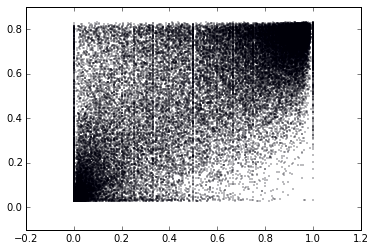

In [60]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

In [61]:
from keras import backend as K

get_3rd_layer_output_1 = K.function([model3.layers[0].input],
                                  [model3.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [62]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [66]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [67]:
r2_score(hal_pred, model_pred)

0.0065571291170595236

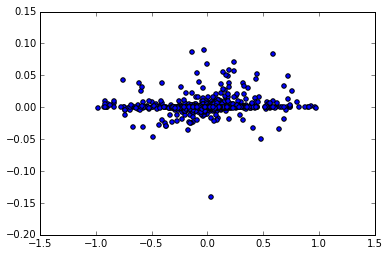

In [68]:
plt.scatter(hal_pred, model_pred)
plt.show()

In [69]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [70]:
r2_score(actual, model_pred_2)

-4.5336678750063086e-05

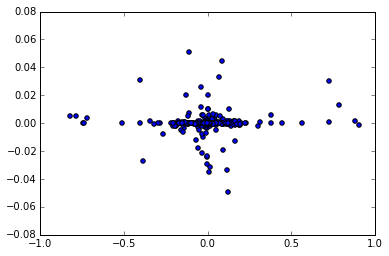

In [71]:
plt.scatter(actual, model_pred_2)
plt.show()

In [73]:
model3.save_weights('../data/recurrent-4.h5')
model_json = model3.to_json()
with open('../data/recurrent-4-model.json', 'w') as f:
    f.write(model_json)


## Conclusion

The various neural network models work well on in-sample cases, but completely fail for predicting the effects of SNPs on splicing. This could be because the varying lengths of the test cases cause weird things to happen for the recurrent layers since they're only trained on constant-length inputs? Or maybe we're not taking into account alt-3' data (even though that did not help predictions earlier)?

Future directions:

- Abandon neural network models
- Try to train on genomic skipped exon data (we failed on alt-5', but that might be more due to a lack of clean data than anything else)
- Try different models - what have we not tried? The recurrent layers might be a problem. Perhaps with a much simpler "sum" layer, it might be able to work better.